In [1]:
from __future__ import division
import numpy as np
import os
import cv2
from PIL import Image
from IPython.display import display
import glob
import random
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib ipympl

In [2]:
root_path = "/home/jacopo.gasparetto/Workspaces/DeepCalculatorBot/ObjectDetection/"
data_path = "extracted_images"
dataset_dir ="dataset"

In [3]:
def generate_datasets(data_dir, out_folder, symbols_required):
    """
    Divide features and label in two different datasets
    """
    from shutil import copyfile
    
    if os.path.isdir(out_folder):
        raise ValueError("dataset folder already present.")
        
    else:
        features_dir = os.path.join(out_folder, "features")
        labels_dir = os.path.join(out_folder, "labels")
        
        # Make base folder structure
        os.mkdir(out_folder)
        os.mkdir(features_dir)
        os.mkdir(labels_dir)
    
    # Get symbols class names
    if symbols_required:
        data_folders = symbols_required
    else:
        data_folders = os.listdir(data_dir)
    
   # Iterate over each class 
    for folder in tqdm(data_folders):
        
        if folder== ".":
                continue
        
        symbols = os.listdir(os.path.join(data_dir, folder))
        print("Copying", folder, " counts:", len(symbols))
        os.mkdir(os.path.join(features_dir, folder))
        os.mkdir(os.path.join(labels_dir, folder))
        for symbol in symbols:
            if symbol[0]== ".":
                continue
            old_path = os.path.join(data_dir, os.path.join(folder, symbol))
            if "_" in symbol:
                new_path = os.path.join(labels_dir, os.path.join(folder, symbol))
            else:
                new_path = os.path.join(features_dir, os.path.join(folder, symbol))
            copyfile(old_path, new_path)

In [5]:
symbols=["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "+", "-", "times", "div", "forward_slash", "(", ")", "[", "]",
         "{", "}", "!", ","]
generate_datasets("extracted_images", dataset_dir, symbols)

Copying 0  counts: 6914
Copying 1  counts: 26520
Copying 2  counts: 26141
Copying 3  counts: 10909
Copying 4  counts: 7396
Copying 5  counts: 3545
Copying 6  counts: 3118
Copying 7  counts: 2909
Copying 8  counts: 3068
Copying 9  counts: 3737
Copying +  counts: 25112
Copying -  counts: 33997
Copying times  counts: 3251
Copying div  counts: 868
Copying forward_slash  counts: 199
Copying (  counts: 14294
Copying )  counts: 14355
Copying [  counts: 778
Copying ]  counts: 780
Copying {  counts: 376
Copying }  counts: 377
Copying !  counts: 1300
Copying ,  counts: 1906



In [6]:
def disp_sample(folders_path, sample_size):
    basename = os.path.basename(folders_path)
    folders = os.listdir(folders_path)
    for folder in folders:
        if folder.startswith("."):
            continue
        print("{}/{}".format(basename, folder))
        folder_path = os.path.join(folders_path, folder)
        image_files = os.listdir(folder_path)
        if len(image_files) == 0:
            continue
        image_samples = random.sample(image_files, sample_size)
        for image in image_samples:
            image_file = os.path.join(folders_path, os.path.join(folder, image))
            i = Image.open(image_file)
            display(i)

features/0


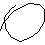

features/1


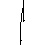

features/2


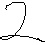

features/3


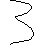

features/4


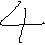

features/5


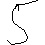

features/6


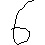

features/7


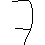

features/8


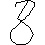

features/9


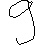

features/+


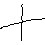

features/-


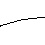

features/times


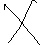

features/div


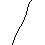

features/forward_slash
features/(


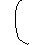

features/)


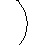

features/[


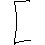

features/]


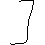

features/{


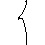

features/}


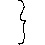

features/!


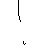

features/,


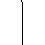

In [7]:
disp_sample("dataset/features", 1)

labels/{


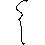

labels/3


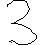

labels/-


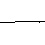

labels/times


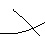

labels/9


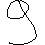

labels/1


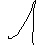

labels/]


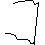

labels/2


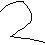

labels/}


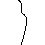

labels/+


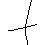

labels/0


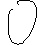

labels/8


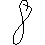

labels/,


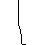

labels/!


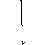

labels/5


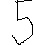

labels/4


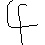

labels/)


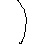

labels/6


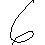

labels/forward_slash


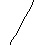

labels/7


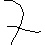

labels/[


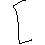

labels/div


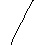

labels/(


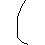

In [80]:
disp_sample("dataset/labels", 1)

## Create fake dataset for object recognition
Create a fake dataset of fixed sized images. 

In [3]:
def pick_random_samples(folders_path, max_sample_size, random_resize=False, crop=False):
    rand = random.randint(3, 8)
    folders = random.sample(os.listdir(folders_path), rand)
    images = []
    for folder in folders:
        folder_path = os.path.join(folders_path, folder)
        image_files = os.listdir(folder_path)
        if len(image_files) == 0:
            continue
        
        sample_size = random.randint(1, max_sample_size)
        image_samples = random.sample(image_files, sample_size)
        for image in image_samples:
            image_file = os.path.join(folders_path, os.path.join(folder, image))
            
            i = cv2.imread(image_file)
            i = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY) # convert to grayscale
             # threshold
            _, i = cv2.threshold(i, thresh=100, maxval=255, type=cv2.THRESH_BINARY)
            i = cv2.erode(i, np.ones((2, 2), np.uint8))
            i = cv2.blur(i, (2,2))

            if random_resize:
                    m = random.uniform(1, 2)
                    w, h = i[0], i[1],
                    i = cv2.resize(i, None, fx=m, fy=m)
        
            if crop:
                points = np.argwhere(i==0)    # find where the black pixels are
                points = np.fliplr(points)              # store them in x,y coordinates instead of row,col indices
                x, y, w, h = cv2.boundingRect(points)   # create a rectangle around those points
                i = i[y:y+h+2, x:x+w+2]               # create a cropped region of the gray image
                # _, i = cv2.threshold(cropped, thresh=200, maxval=255, type=cv2.THRESH_BINARY) # get the thresholded crop
                
            images.append((i, folder))
    return images

In [11]:
def create_one_composite_sample(width, height):

    images_data = pick_random_samples("dataset/features", max_sample_size=1, random_resize=False, crop=True)
    if len(images_data) > 0:
        images, class_names = zip(*images_data)
    else:
        print(images_data)
    
    new_im = np.full((width, height), 255)
    bboxes = []
    labels = [] 

    def intersect(bbox1, bbox2):
           return (abs(bbox1["x"] - bbox2["x"]) < abs(bbox1["w"] + bbox2["w"]) / 2) and (abs(bbox1["y"] - bbox2["y"]) < (abs(bbox1["h"] + bbox2["h"]) / 2))

    for i in range(len(images)):
        img = images[i]
        _, _, w, h = cv2.boundingRect(img)
        bbox_offset_px = 2
        
        min_x, max_x = w - bbox_offset_px, width - w - bbox_offset_px
        min_y, max_y = h - bbox_offset_px, height - h - bbox_offset_px

        x = random.randint(min_x, max_x)
        y = random.randint(min_y, max_y)
        bbox = {
            "x": x - bbox_offset_px,
            "y": y - bbox_offset_px,
            "w": w + bbox_offset_px,
            "h": h + bbox_offset_px
        }
        j = 0
        hasCollision = False
        while j < len(labels):
            if j == i:
                continue

            if intersect(bbox, labels[j]["bbox"]):
                x = random.randint(min_x, max_x)
                y = random.randint(min_y, max_y)
                bbox = {
                    "x": x - bbox_offset_px,
                    "y": y - bbox_offset_px,
                    "w": w + bbox_offset_px,
                    "h": h + bbox_offset_px
                }
                j = 0
                continue
            j += 1
        labels.append({
            "class_name": class_names[i],
            "bbox": bbox
        })
        
        new_im[y:y+img.shape[0], x:x+img.shape[1]] = img

    return new_im, labels

( 326 352 71 118
6 312 343 155 202
3 356 390 95 142
+ 160 202 44 91
1 285 308 43 90
div 77 124 308 348


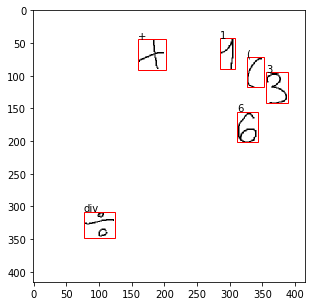

In [6]:
img, labels = create_one_composite_sample(416, 416)
class_names = [l["class_name"] for l in labels]
bboxes = [l["bbox"] for l in labels]

fig = plt.figure(figsize=(5, 5))
plt.imshow(img, cmap=plt.cm.gray)
[plt.gca().add_patch(Rectangle((label["bbox"]["x"], label["bbox"]["y"]), label["bbox"]["w"], label["bbox"]["h"], ec='r', fc='none')) for label in labels]
[plt.gca().text(label["bbox"]["x"], label["bbox"]["y"], label["class_name"]) for label in labels]
cv2.imwrite("test_img.png", img)

for label in labels:
    print(" ".join([label["class_name"], 
                    str(label["bbox"]["x"]), 
                    str(label["bbox"]["x"] + label["bbox"]["w"]), 
                    str(label["bbox"]["y"]), 
                    str(label["bbox"]["y"] + label["bbox"]["h"])]))


In [8]:
def generate_composite_dataset(path, num_samples):
    if os.path.isdir(path):
        raise ValueError("Folder already exists")
    else:
        features_path = os.path.join(path, "features")
        labels_path = os.path.join(path, "labels")
        os.mkdir(path)
        os.mkdir(features_path)
        os.mkdir(labels_path)
        
    for i in range(num_samples):
        img, labels = create_one_composite_sample()
        img.save(os.path.join(features_path, "{}.png".format(i)))
           
        strings = [" ".join([label["class_name"], 
                    str(label["bbox"]["x"]), 
                    str(label["bbox"]["x"] + label["bbox"]["w"]), 
                    str(label["bbox"]["y"]), 
                    str(label["bbox"]["y"] + label["bbox"]["h"])]) for label in labels]
        
        with open(os.path.join(labels_path, "{}.txt".format(i)), "w") as text_file:
            text_file.write("\n".join(strings))

In [9]:
generate_composite_dataset("fake_dataset", 100)

In [8]:
def generate_xml_annotations(path, num_samples, width=416, height=416, overwrite=False):
    import xml.etree.ElementTree as ET
    import shutil

    path = os.path.abspath(path)
    labels_path = os.path.join(path, "labels")
    features_path = os.path.join(path, "features")
    
    if os.path.isdir(path) and not overwrite:
        raise ValueError("Folder already exists")
    else:
        if os.path.isdir(path):
            shutil.rmtree(path)
        os.mkdir(path)
        os.mkdir(labels_path)
        os.mkdir(features_path)
        
        for i in tqdm(range(num_samples)):
            img, labels = create_one_composite_sample(width, height)
            png_name = "{}.png".format(i)
            txt_name = "{}.txt".format(i)
            cv2.imwrite(os.path.join(features_path, png_name), img)
            
            annotation = ET.Element("annotation")
            ET.SubElement(annotation, "folder").text = features_path
            ET.SubElement(annotation, "filename").text = png_name
            ET.SubElement(annotation, "path").text = os.path.join(features_path, png_name)
            ET.SubElement(annotation, "source").text = "Unknown"

            size = ET.SubElement(annotation, "size")
            ET.SubElement(size, "width").text = "{}".format(width)
            ET.SubElement(size, "height").text = "{}".format(height)
            ET.SubElement(size, "depth").text = "3"
            
            ET.SubElement(annotation, "segmented").text = "0"
            
            for label in labels:
                obj = ET.SubElement(annotation, "object")
                ET.SubElement(obj, "name").text = label["class_name"]
                ET.SubElement(obj, "pose").text = "Unspecified"
                ET.SubElement(obj, "truncated").text = "0"
                ET.SubElement(obj, "difficult").text = "0"
                ET.SubElement(obj, "occluded").text = "0"
                
                bndbox = ET.SubElement(obj, "bndbox")
                ET.SubElement(bndbox, "xmin").text = str(label["bbox"]["x"])
                ET.SubElement(bndbox, "xmax").text = str(label["bbox"]["x"] + label["bbox"]["w"])
                ET.SubElement(bndbox, "ymin").text = str(label["bbox"]["y"])
                ET.SubElement(bndbox, "ymax").text = str(label["bbox"]["y"] +label["bbox"]["h"])
            
            tree = ET.ElementTree(annotation)
            tree.write(os.path.join(labels_path, txt_name))
            

In [13]:
generate_xml_annotations(os.path.join(root_path, "xml_dataset/train"), 10000, overwrite=True)
generate_xml_annotations(os.path.join(root_path, "xml_dataset/valid"), 1000, overwrite=True)